# StackBox

In this notebook we are going to apply StackBox algorithm.
In the first stage, we are going to apply StackBox to the predictions on the training data.
In the second stage, we are going to prepare the test data to apply stacking models using stackbox.

__As input files in the first stage, we should have :__
- the predictions obtained using different models on the training data, in the format <filename, score, xmin, ymin, xmax, ymax>
- the ground truth in the format <filename, xmin, ymin, xmax, ymax>

__In the second stage, we need:__
- the predictions obtained using different models on the test data, in the format <filename, score, xmin, ymin, xmax, ymax>

__Finally, to compare the results between the baseline models and the result of the StackBox, we should have:__
- A folder with the images to comparison
- The ground truth for the test dataset, in the format <filename, xmin, ymin, xmax, ymax>

In [1]:
# the path for the excel file that contains the ground truth
input_gt = r'.\Files\ground_truth.xlsx'
# the path for the folder that contains the predicitions made by the models in the training data
input_pred_train = r'.\Files\predictions_train'

# the path for the folder that contains the predictions by the models in the test data
input_pred_test = r'.\Files\predictions_test'

###### For the example at the end
folder_images = r'.\Images'
gt_test_file = r'.\Files\gt_test.xlsx'

## Stage 1 - Apply StackBox in the training data

In this stage, we are going to find out, for each ground truth box, the best predicted box for each model. <br>
We need to define the file that contains the ground-truth in the object "input_gt" and the path for the folder that contains the predictions for the different models in the object "input_pred_train".

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Get the ground-truth into a dataframe
gt_file = pd.read_excel(input_gt)

# Get the train predictions into different dataframes, one for each models' predictions
excel_file_list = os.listdir(input_pred_train) # the files in the train folder
models = [x[:-5] for x in excel_file_list] # get the name of the models without extension
for model in models: # we create a new object for the predictions of each model that we have available
    vars()[model] = pd.read_excel(input_pred_train + '\\' + model + '.xlsx')
    print('Models predictions available:', model)

eff
#ret
#yol

Models predictions available: eff
Models predictions available: ret
Models predictions available: yol


,filename,scores,xmin,ymin,xmax,ymax
0,4ec3d46e602b296cc5cfd263f1f90be2,0.989900,400.312958,170.689529,458.076874,263.387695
1,34e222e19769fa2d37d32780fd497e1c,0.983757,158.930115,258.535706,350.023376,432.684265
2,34e222e19769fa2d37d32780fd497e1c,0.953698,305.583984,122.293419,370.516479,174.392273
3,ee17979870116d06046f5d8dd18841d3,0.990982,377.776306,192.728790,533.453064,365.034210
4,4539ef2424a9218697283baa3657e431,0.996158,136.270874,156.300995,256.034058,302.858398
...,...,...,...,...,...,...
923,0adabead1ae730831caf386f6e366943,0.990403,229.282440,124.980873,393.323944,288.601501
924,dbd7e6afd56ea7bc4ba26c86b345408c,0.987988,157.779755,157.740814,304.589630,355.809967
925,ef92846b60b1a38a1eecd70ebce6347c,0.993315,316.099030,201.250641,435.744904,333.372589
926,cdc265a0b0a1230b118fa8625605da20,0.996193,281.164429,228.186432,384.691956,331.079926


In [3]:
def bb_intersection_over_union(boxA, boxB):
    """
    Determine the (x,y) coordinates of the intersection rectangle and return the Intersection over Union (IoU)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intesection area and dividing it by 
    # the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

#### Merge with models predictions

In [4]:
def iou_gt_predictions(model_pred, gt_file, id_model):
    """
    Provide to each GT bounding box, the predicted box for each model with the highest IoU
    """
    df_model = pd.merge(gt_file, model_pred, how = 'left', left_on = gt_file['filename'], right_on = model_pred['filename'])
    df_model.drop(['key_0', 'filename_y'], axis = 1, inplace = True)
    df_model.columns = ['filename','xmin_gt', 'ymin_gt','xmax_gt','ymax_gt', 'scores_' + id_model ,'xmin_' + id_model,'ymin_' + id_model,'xmax_' + id_model,'ymax_' + id_model] 
    for index, row in df_model.iterrows():
        boxA = list(row[['xmin_gt','ymin_gt','xmax_gt','ymax_gt']])
        boxB = list(row[['xmin_' + id_model,'ymin_' + id_model,'xmax_' + id_model,'ymax_' + id_model]])
        iou = bb_intersection_over_union(boxA, boxB)
        df_model.loc[index,'iou_' + id_model] = iou
    
    df_model = df_model.fillna(-1)
    df_model = df_model.loc[df_model.groupby(['filename','xmin_gt','ymin_gt','xmax_gt','ymax_gt'])['iou_' + id_model].idxmax()]
    return df_model

In [5]:
# for each dataframe that we have of the predictions in train, get the IoU using as basis the ground-truth file
for model in models:
    vars()[model] = iou_gt_predictions(globals()[model], gt_file, model)

Now that we combine the predictions from the ground truth with each of the models and calculate the IoU with the ground truth boxes, we can merge all the results into a single dataframe:

In [6]:
from functools import reduce

data_frames = []
for model in models:
    data_frames.append(globals()[model])
df_merged_train = reduce(lambda left,right: pd.merge(left,right,left_on=['filename','xmin_gt','ymin_gt','xmax_gt','ymax_gt'],
                                               right_on=['filename','xmin_gt','ymin_gt','xmax_gt','ymax_gt'], 
                                               how='left'), data_frames)

print('We have ' + str(df_merged_train.shape[0]) + ' rows available, where each of those correspond to a ground-truth object.')
df_merged_train = df_merged_train.loc[:, ~df_merged_train.columns.str.startswith('scores')] # remove the scores columns, since we don't need those
df_merged_train

We have 938 rows available, where each of those correspond to a ground-truth object.


,filename,xmin_gt,ymin_gt,xmax_gt,ymax_gt,xmin_eff,ymin_eff,xmax_eff,ymax_eff,iou_eff,xmin_ret,ymin_ret,xmax_ret,ymax_ret,iou_ret,xmin_yol,ymin_yol,xmax_yol,ymax_yol,iou_yol
0,0081835cf877e004e8bfb905b78a9139,258.5,544.804020,393.0,616.844221,258.773376,497.830139,393.879883,550.502991,0.055588,257.781677,493.149109,396.120056,550.970642,0.056715,262.843872,494.659821,391.089172,551.292053,0.059092
1,00d827b8bcf15050fb9af0ef92846b60,180.0,283.658291,379.0,445.105528,183.116943,292.935730,377.672424,413.214355,0.729982,176.585632,288.427734,380.383789,418.463684,0.791323,184.717865,290.360413,380.079315,418.232910,0.771303
2,00f9b6c911c4aa179344271fa54aa1b2,347.5,200.875912,473.0,386.402503,349.315521,230.860626,473.386932,370.233917,0.740060,346.571136,228.118011,473.816437,368.958710,0.752536,347.091644,230.431580,473.744904,370.130005,0.749156
3,00fd197cd955fa095f978455cef3593c,155.5,79.918117,326.0,359.631525,165.832596,139.350754,325.045410,350.138489,0.704808,149.603516,131.482666,337.901917,358.813446,0.750077,156.403015,137.091980,323.242584,353.905029,0.759366
4,01c13a3d810b000db55759486b8aa1b8,346.0,23.155779,484.0,120.281407,348.060486,89.798416,487.777588,164.360489,0.215984,350.689453,90.137878,487.859924,166.313995,0.207898,346.609192,89.103035,486.317078,163.337524,0.225223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,fe1bce59ddf92e76900d229db65646d8,371.0,277.226131,499.0,432.884422,371.658936,291.075684,501.615662,407.696899,0.735777,372.061584,278.442841,503.171448,408.725555,0.809195,372.142242,287.885712,499.805756,406.381927,0.752443
934,fe51330463d287a51b9298e11bb07c70,220.0,193.244626,401.5,303.950870,220.691467,224.397308,405.137390,305.680817,0.697390,220.401001,222.308746,398.422302,310.258331,0.687628,219.864914,223.005829,396.071594,305.093231,0.704379
935,fe9959a80703003d2cbbcfa4baf38662,318.5,310.990615,406.5,445.130344,319.569336,311.387787,406.810181,411.824005,0.739649,317.048462,308.849976,407.932556,414.351685,0.741561,319.711365,314.847504,406.681519,411.699005,0.713168
936,ff13a2da7be59a5529406ac1c91f53b8,200.0,172.381910,326.5,355.055276,197.581207,204.411133,327.695953,348.367554,0.771936,199.045929,201.465378,328.123749,343.618225,0.767297,198.939392,204.218811,327.738220,347.134399,0.772626


At this point, we already have the object `df_merged_train`, that contains at each row:
- the ground-truth, i.e., the filename (name of the image), the xmin, ymin, xmax and ymax for each object
- the coordinates of each prediction for each model that has the highest IoU with each ground-truth object, and the respective IoU

####  Fill missing values and remove duplicates

At this point, our dataframe can include some rows where:
- there is no prediction available (i.e, where no model was able to detect a box that has a IoU higher than 0 with that object)
- there are some predictions for one specific object, but not all models where able to detect that object.

The indexes that follows those previous conditions are going to be stored in two different lists: `indexes_to_drop_train` and `indexes_to_fill_train`, respectively. 

In [7]:
indexes_to_drop_train = [] # this will contain the indexes of the rows that should be removed, since no prediction is associated
indexes_to_fill_train = [] # this will contain the indexes of the rows where at least one prediction is missing

In [8]:
# the name of the columns that contains the IoU for each model
cols =  df_merged_train.columns[df_merged_train.columns.str.startswith('iou')].tolist() 

# get all rows where there is no prediction available to drop it
for index, row in df_merged_train.iterrows():
    if all(row[col] <=0 for col in cols): # if all IoU' columns are lower than 0
        indexes_to_drop_train.append(index)

print('Indexes to drop (no prediction available):', indexes_to_drop_train)
df_clean_train = df_merged_train.drop(indexes_to_drop_train)
print('\nThere was ' + str(len(indexes_to_drop_train)) + ' ground-truth objects with no predictions associated.')
print('The dataset has now ' + str(df_clean_train.shape[0]) + ' rows.')

Indexes to drop (no prediction available): [148, 165, 355, 407, 408, 409, 452, 494, 521, 522, 524, 539, 540, 541, 543, 544, 594, 633, 707, 832, 833, 835, 848]

There was 23 ground-truth objects with no predictions associated.
The dataset has now 915 rows.


At this point, the `df_clean_train` is a dataframe where the rows with the ground-truth objects that aren't associated with any prediction were dropped.

In [9]:
df_clean_train

,filename,xmin_gt,ymin_gt,xmax_gt,ymax_gt,xmin_eff,ymin_eff,xmax_eff,ymax_eff,iou_eff,xmin_ret,ymin_ret,xmax_ret,ymax_ret,iou_ret,xmin_yol,ymin_yol,xmax_yol,ymax_yol,iou_yol
0,0081835cf877e004e8bfb905b78a9139,258.5,544.804020,393.0,616.844221,258.773376,497.830139,393.879883,550.502991,0.055588,257.781677,493.149109,396.120056,550.970642,0.056715,262.843872,494.659821,391.089172,551.292053,0.059092
1,00d827b8bcf15050fb9af0ef92846b60,180.0,283.658291,379.0,445.105528,183.116943,292.935730,377.672424,413.214355,0.729982,176.585632,288.427734,380.383789,418.463684,0.791323,184.717865,290.360413,380.079315,418.232910,0.771303
2,00f9b6c911c4aa179344271fa54aa1b2,347.5,200.875912,473.0,386.402503,349.315521,230.860626,473.386932,370.233917,0.740060,346.571136,228.118011,473.816437,368.958710,0.752536,347.091644,230.431580,473.744904,370.130005,0.749156
3,00fd197cd955fa095f978455cef3593c,155.5,79.918117,326.0,359.631525,165.832596,139.350754,325.045410,350.138489,0.704808,149.603516,131.482666,337.901917,358.813446,0.750077,156.403015,137.091980,323.242584,353.905029,0.759366
4,01c13a3d810b000db55759486b8aa1b8,346.0,23.155779,484.0,120.281407,348.060486,89.798416,487.777588,164.360489,0.215984,350.689453,90.137878,487.859924,166.313995,0.207898,346.609192,89.103035,486.317078,163.337524,0.225223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,fe1bce59ddf92e76900d229db65646d8,371.0,277.226131,499.0,432.884422,371.658936,291.075684,501.615662,407.696899,0.735777,372.061584,278.442841,503.171448,408.725555,0.809195,372.142242,287.885712,499.805756,406.381927,0.752443
934,fe51330463d287a51b9298e11bb07c70,220.0,193.244626,401.5,303.950870,220.691467,224.397308,405.137390,305.680817,0.697390,220.401001,222.308746,398.422302,310.258331,0.687628,219.864914,223.005829,396.071594,305.093231,0.704379
935,fe9959a80703003d2cbbcfa4baf38662,318.5,310.990615,406.5,445.130344,319.569336,311.387787,406.810181,411.824005,0.739649,317.048462,308.849976,407.932556,414.351685,0.741561,319.711365,314.847504,406.681519,411.699005,0.713168
936,ff13a2da7be59a5529406ac1c91f53b8,200.0,172.381910,326.5,355.055276,197.581207,204.411133,327.695953,348.367554,0.771936,199.045929,201.465378,328.123749,343.618225,0.767297,198.939392,204.218811,327.738220,347.134399,0.772626


Now, we need to find out each rows do not have all predictions available, and fill those with the prediction of the model that has the highest IoU with the ground-truth.

In [10]:
df_to_fill_train = df_clean_train.reset_index(drop=True)

for index, row in df_to_fill_train.iterrows():
    if (any(row[col] <=0 for col in cols) == 1) == True:
        indexes_to_fill_train.append(index)

print('Indexes to fill (at least one prediction missing):', indexes_to_fill_train)
print('\nWe have ' + str(len(indexes_to_fill_train)) + ' rows where at least one prediction is missing.')

Indexes to fill (at least one prediction missing): [12, 23, 67, 189, 216, 236, 237, 328, 341, 428, 429, 431, 512, 527, 555, 578, 579, 644, 778, 805, 811, 812, 813, 849, 876, 887, 896, 899, 901, 903, 906]

We have 31 rows where at least one prediction is missing.


In [11]:
# Find the columns that contains the IoU and get the column for each row with the highest value. 
# This will be the the prediction that we use to fill the missing predictions
iou_cols = df_to_fill_train.filter(regex="iou")
max_list = iou_cols.idxmax(axis=1).str[4:] # this is the maximum
max_list

0      yol
1      ret
2      ret
3      yol
4      yol
      ... 
910    ret
911    yol
912    ret
913    yol
914    yol
Length: 915, dtype: object

In [12]:
# get all rows where at least one prediction is not available
to_fill_train = df_to_fill_train.iloc[indexes_to_fill_train]

# define which columns you don't want to change, i.e., the Ground-truth columns
to_fill_gt = to_fill_train.iloc[:,:5]
# define which columns are predictions
others = to_fill_train.iloc[:,5:]

# create one dataframe for each of the models
num_cols = int(others.shape[1]/len(models)) # This will give us the number of columns associated with each model

i = 0
for name in models:
    last = int(num_cols+i)
    vars()[name] = others.iloc[:,i:last]
    i+=num_cols

Now we can call each model individually, and check which rows have problems:

In [13]:
#eff
#ret
#yol

Now, for each row in each model dataframe that we have, if the IoU is equal or lower than 0, we are going to obtain the predictions for the model that has the highest IoU and fill those problematic rows with those values.

In [14]:
for model in models:
    model_name = str(model)
    data = globals()[model]
    for index, row in data.iterrows():
        if row['iou_' + model_name] <=0:
            model_winner = str(max_list[index]) # the winner model with highest IoU
            winner_values = globals()[model_winner].loc[[index]] # the values from the winner model
            data.loc[[index]] = winner_values

At this point, we already fill all the problematic rows, for each of the models, with the prediction with the highest IoU.<br>
Now, we are going to:
- merge the ground-truth dataframe `to_fill_gt` with each models dataframe;
- Substitute the problematic rows in the full dataframe `df_to_fill_train` with the new rows.

In [15]:
models_filled = [to_fill_gt]
for model in models:
    models_filled.append(globals()[model])
filled_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), models_filled)

# substitute the old dataframe (df_to_fill_train) with the corrected rows
df_to_fill_train.loc[filled_merged.index, :] = filled_merged[:]
df_train = df_to_fill_train.copy()
df_train

,filename,xmin_gt,ymin_gt,xmax_gt,ymax_gt,xmin_eff,ymin_eff,xmax_eff,ymax_eff,iou_eff,xmin_ret,ymin_ret,xmax_ret,ymax_ret,iou_ret,xmin_yol,ymin_yol,xmax_yol,ymax_yol,iou_yol
0,0081835cf877e004e8bfb905b78a9139,258.5,544.804020,393.0,616.844221,258.773376,497.830139,393.879883,550.502991,0.055588,257.781677,493.149109,396.120056,550.970642,0.056715,262.843872,494.659821,391.089172,551.292053,0.059092
1,00d827b8bcf15050fb9af0ef92846b60,180.0,283.658291,379.0,445.105528,183.116943,292.935730,377.672424,413.214355,0.729982,176.585632,288.427734,380.383789,418.463684,0.791323,184.717865,290.360413,380.079315,418.232910,0.771303
2,00f9b6c911c4aa179344271fa54aa1b2,347.5,200.875912,473.0,386.402503,349.315521,230.860626,473.386932,370.233917,0.740060,346.571136,228.118011,473.816437,368.958710,0.752536,347.091644,230.431580,473.744904,370.130005,0.749156
3,00fd197cd955fa095f978455cef3593c,155.5,79.918117,326.0,359.631525,165.832596,139.350754,325.045410,350.138489,0.704808,149.603516,131.482666,337.901917,358.813446,0.750077,156.403015,137.091980,323.242584,353.905029,0.759366
4,01c13a3d810b000db55759486b8aa1b8,346.0,23.155779,484.0,120.281407,348.060486,89.798416,487.777588,164.360489,0.215984,350.689453,90.137878,487.859924,166.313995,0.207898,346.609192,89.103035,486.317078,163.337524,0.225223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,fe1bce59ddf92e76900d229db65646d8,371.0,277.226131,499.0,432.884422,371.658936,291.075684,501.615662,407.696899,0.735777,372.061584,278.442841,503.171448,408.725555,0.809195,372.142242,287.885712,499.805756,406.381927,0.752443
911,fe51330463d287a51b9298e11bb07c70,220.0,193.244626,401.5,303.950870,220.691467,224.397308,405.137390,305.680817,0.697390,220.401001,222.308746,398.422302,310.258331,0.687628,219.864914,223.005829,396.071594,305.093231,0.704379
912,fe9959a80703003d2cbbcfa4baf38662,318.5,310.990615,406.5,445.130344,319.569336,311.387787,406.810181,411.824005,0.739649,317.048462,308.849976,407.932556,414.351685,0.741561,319.711365,314.847504,406.681519,411.699005,0.713168
913,ff13a2da7be59a5529406ac1c91f53b8,200.0,172.381910,326.5,355.055276,197.581207,204.411133,327.695953,348.367554,0.771936,199.045929,201.465378,328.123749,343.618225,0.767297,198.939392,204.218811,327.738220,347.134399,0.772626


At this moment, all the needed corrections were made in the train dataframe, and this dataframe will be used in the stage 3.

## Stage 2 - Apply StackBox in the test data

In [16]:
# Get the test predictions into different dataframes, one for each models' predictions
excel_file_list_test = os.listdir(input_pred_test) # the files in the test folder
models_test = [x[:-5] for x in excel_file_list_test] # get the name of the models without extension
for model in models_test: # we create a new object for the predictions of each model that we have available
    vars()[model] = pd.read_excel(input_pred_test + '\\' + model + '.xlsx')
    print('Models predictions available:', model)

Models predictions available: test_eff
Models predictions available: test_ret
Models predictions available: test_yol


In [17]:
def iou_gt_test(model_pred, gt_file, id_model, name_gt):
    """
    This function will provide to each GT bounding box, the predicted box for each model with the highest IoU
    """
    df_model = pd.merge(gt_file, model_pred, how = 'left', left_on = gt_file['filename'], right_on = model_pred['filename'])
    df_model.drop(['key_0', 'filename_y'], axis = 1, inplace = True)
    
    df_model.columns = ['filename','scores_' + name_gt,'xmin_' + name_gt, 'ymin_' + name_gt,'xmax_' + name_gt,'ymax_' + name_gt,'scores_' + id_model ,'xmin_' + id_model,'ymin_' + id_model,'xmax_' + id_model,'ymax_' + id_model] 
 
    for index, row in df_model.iterrows():
        boxA = list(row[['xmin_' + name_gt,'ymin_' + name_gt,'xmax_' + name_gt,'ymax_' + name_gt]])
        boxB = list(row[['xmin_' + id_model,'ymin_' + id_model,'xmax_' + id_model,'ymax_' + id_model]])
        iou = bb_intersection_over_union(boxA, boxB)
        df_model.loc[index,'iou_' + id_model] = iou
    
    df_model = df_model.fillna(-1)
    df_model = df_model.loc[df_model.groupby(['filename','xmin_' + name_gt,'ymin_' + name_gt,'xmax_' + name_gt,'ymax_' + name_gt])['iou_' + id_model].idxmax()]
    return df_model

At this point, for the predictions of each model that we have, we are going to consider, one at a time, the ground truth, and calculate the IoU with the predictions of the other models.

In [18]:
# do the needed rotation, where the first element of each list is going to be the GT, and the remaining the predictions
x = models_test
result = [x[-i:]+x[:-i] for i in range(len(x))]
result

[['test_eff', 'test_ret', 'test_yol'],
 ['test_yol', 'test_eff', 'test_ret'],
 ['test_ret', 'test_yol', 'test_eff']]

In [19]:
combs = []
for element in result:
    gt_test = globals()[element[0]]
    others_test = element[1:] # the predictions are the remaining models
    for other in others_test:
        name_comb = 'gt_' + element[0] + '_and_' + other
        print(name_comb)
        combs.append(name_comb)
        vars()[name_comb] = iou_gt_test(globals()[other], gt_test, other, element[0])

gt_test_eff_and_test_ret
gt_test_eff_and_test_yol
gt_test_yol_and_test_eff
gt_test_yol_and_test_ret
gt_test_ret_and_test_yol
gt_test_ret_and_test_eff


In [20]:
gt_test_eff_and_test_ret

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
137,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
126,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
3,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
198,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
63,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...
24,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.909615,178.726227,172.949341,389.542389,297.845612,0.691233
164,fb256f174ae992b915a51625559c7e61,0.975927,187.944611,169.960266,438.403168,314.986755,0.838659,186.462570,168.332642,446.008850,316.903381,0.942251
218,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.983463,162.919998,188.734879,250.535660,288.117432,0.941219
123,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.939462,285.294525,321.328156,356.621735,394.462006,0.720621


Now we already merge the "ground truth" with each of the predictions, where the predictions associated are the objects with the highest IoU with the ground truth. Now we need to merge each of those dataframes where the GT is the same.

In [21]:
number_models = len(models_test) # this is the total number of models used
number_combs = len(combs) # this is the total number of combinations
splits = np.array_split(combs, number_models) # we split the combinations, so we can obtain the dataframes that should be combined
splits

[array(['gt_test_eff_and_test_ret', 'gt_test_eff_and_test_yol'],
       dtype='<U24'),
 array(['gt_test_yol_and_test_eff', 'gt_test_yol_and_test_ret'],
       dtype='<U24'),
 array(['gt_test_ret_and_test_yol', 'gt_test_ret_and_test_eff'],
       dtype='<U24')]

In [22]:
names_gt = []
for element in splits:
    name_gt = element[0].split('_and_')[0] # the name of the gt (for example: gt_test_eff)
    name_model = name_gt.split('_')[2] # the name of the model (for example: eff)
    data_frames = []
    for model in element:
        data_frames.append(globals()[model])
    # merge the data where the GT is the same
    vars()[name_gt] = reduce(lambda left,right: pd.merge(left,right,left_on=['filename',
                                                                             'scores_test_' + name_model,
                                                                             'xmin_test_' + name_model,
                                                                             'ymin_test_' + name_model,
                                                                             'xmax_test_' + name_model,
                                                                             'ymax_test_' + name_model],
                                                   right_on=['filename',
                                                             'scores_test_' + name_model,
                                                             'xmin_test_' + name_model,
                                                             'ymin_test_' + name_model,
                                                             'xmax_test_' + name_model,
                                                             'ymax_test_' + name_model],
                                                   how='left'), data_frames)
    names_gt.append(name_gt)
    print('Dataframe built:', name_gt )

Dataframe built: gt_test_eff
Dataframe built: gt_test_yol
Dataframe built: gt_test_ret


In [23]:
gt_test_eff
#gt_test_yol
#gt_test_ret

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.909615,178.726227,172.949341,389.542389,297.845612,0.691233,0.501135,180.701935,210.623688,376.424774,293.655701,0.891594
220,fb256f174ae992b915a51625559c7e61,0.975927,187.944611,169.960266,438.403168,314.986755,0.838659,186.462570,168.332642,446.008850,316.903381,0.942251,0.919696,189.168274,170.985870,430.587524,315.346558,0.955013
221,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.983463,162.919998,188.734879,250.535660,288.117432,0.941219,0.905750,161.657684,188.877365,250.347870,290.291016,0.937586
222,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.939462,285.294525,321.328156,356.621735,394.462006,0.720621,0.897260,294.968201,330.381348,355.347046,394.773560,0.902818


At this point, all the combinations are merged, where each of the models will be associated as the GT, one at each time.
Forward, we are going to concatenate all the dataframes and finally, such as we did in the training dataset, we drop the empty rows and fill the rows where at least one prediction is missing.

#### Concatenate everything

In [24]:
all_df = []
cols_right_order = ['filename'] # save the name of the columns in the right order
for name_gt in names_gt:
    model = name_gt.split('_')[2]
    cols_right_order.append('scores_test_' + model)
    cols_right_order.append('xmin_test_' + model)
    cols_right_order.append('ymin_test_' + model)
    cols_right_order.append('xmax_test_' + model)
    cols_right_order.append('ymax_test_' + model)
    cols_right_order.append('iou_test_' + model)
    
    dataframe = globals()[name_gt]
    all_df.append(dataframe)

all_data = pd.concat(all_df)
all_data = all_data[cols_right_order]
all_data # this will contain all the datasets already merged and concatenated

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,NaN,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,NaN,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,NaN,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,NaN,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,NaN,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.691233,0.501135,180.701935,210.623688,376.424774,293.655701,0.619908,0.909615,178.726227,172.949341,389.542389,297.845612,NaN
215,fb256f174ae992b915a51625559c7e61,0.975927,187.944611,169.960266,438.403168,314.986755,0.942251,0.919696,189.168274,170.985870,430.587524,315.346558,0.904238,0.838659,186.462570,168.332642,446.008850,316.903381,NaN
216,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.941219,0.905750,161.657684,188.877365,250.347870,290.291016,0.961708,0.983463,162.919998,188.734879,250.535660,288.117432,NaN
217,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.720621,0.897260,294.968201,330.381348,355.347046,394.773560,0.742346,0.939462,285.294525,321.328156,356.621735,394.462006,NaN


In [25]:
# drop any duplicates if any and fill any missing values with 0 if any
no_dup_fill_empty = all_data.drop_duplicates()
no_dup_fill_empty.fillna(0, inplace = True)
no_dup_fill_empty

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.000000,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.000000,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.000000,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.000000,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.000000,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.691233,0.501135,180.701935,210.623688,376.424774,293.655701,0.619908,0.909615,178.726227,172.949341,389.542389,297.845612,0.000000
215,fb256f174ae992b915a51625559c7e61,0.975927,187.944611,169.960266,438.403168,314.986755,0.942251,0.919696,189.168274,170.985870,430.587524,315.346558,0.904238,0.838659,186.462570,168.332642,446.008850,316.903381,0.000000
216,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.941219,0.905750,161.657684,188.877365,250.347870,290.291016,0.961708,0.983463,162.919998,188.734879,250.535660,288.117432,0.000000
217,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.720621,0.897260,294.968201,330.381348,355.347046,394.773560,0.742346,0.939462,285.294525,321.328156,356.621735,394.462006,0.000000


Like we did in the training dataset, we can have some rows where:
- there is no prediction available (i.e, where no model was able to detect a box that has a IoU higher than 0 with that object)
- there are some predictions for one specific object, but not all models where able to detect that object.

The indexes that follows those previous conditions are going to be stored in two different lists: `indexes_to_drop_test` and `indexes_to_fill_test`, respectively. 

In [26]:
indexes_to_drop_test = [] # this will contain the indexes of the rows that should be removed, since no prediction is associated
indexes_to_fill_test = [] # this will contain the indexes of the rows where at least one prediction is missing

In [27]:
# the name of the columns that contains the IoU for each model
cols =  no_dup_fill_empty.columns[no_dup_fill_empty.columns.str.startswith('iou')].tolist()
print(cols)

# get all rows where there is no prediction available to drop it
for index, row in no_dup_fill_empty.iterrows():
    if all(row[col] <=0 for col in cols): # if all IoU' columns are equal or lower than 0
        indexes_to_drop_test.append(index)

print('Indexes to drop (no prediction available):', indexes_to_drop_test)
df_clean_test = no_dup_fill_empty.drop(indexes_to_drop_test)
print('\nThere was ' + str(len(indexes_to_drop_test)) + ' ground-truth objects with no predictions associated.')
print('The dataset has now ' + str(df_clean_test.shape[0]) + ' rows.')

['iou_test_eff', 'iou_test_yol', 'iou_test_ret']
Indexes to drop (no prediction available): [33, 72, 74, 114, 158, 17, 26, 29, 35, 54, 93, 144, 175, 176, 215, 225, 226, 45, 99, 141, 155, 181]

There was 22 ground-truth objects with no predictions associated.
The dataset has now 610 rows.


At this point, the `df_clean_test` is a dataframe where the rows with the ground-truth objects that aren't associated with any prediction were dropped.

In [28]:
df_clean_test

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.000000,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.000000,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.000000,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.000000,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.000000,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,f6d32b726342865f6c240449ad43fe2c,0.981730,317.727478,183.477356,487.362122,316.208527,0.967440,0.927159,318.562836,184.429443,484.779633,315.289734,0.966841,0.989377,315.459900,184.223267,485.428772,316.612762,0.000000
214,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.691233,0.501135,180.701935,210.623688,376.424774,293.655701,0.619908,0.909615,178.726227,172.949341,389.542389,297.845612,0.000000
216,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.941219,0.905750,161.657684,188.877365,250.347870,290.291016,0.961708,0.983463,162.919998,188.734879,250.535660,288.117432,0.000000
217,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.720621,0.897260,294.968201,330.381348,355.347046,394.773560,0.742346,0.939462,285.294525,321.328156,356.621735,394.462006,0.000000


Now, we need to find out each rows do not have all predictions available, and fill those with the prediction of the model that has the highest IoU with the ground-truth.

In [29]:
df_to_fill_test = df_clean_test.reset_index(drop=True)

for index, row in df_to_fill_test.iterrows():
    if (any(row[col] <0 for col in cols) == 1) == True:
        indexes_to_fill_test.append(index)

print('Indexes to fill (at least one prediction missing):', indexes_to_fill_test)
print('\nWe have ' + str(len(indexes_to_fill_test)) + ' rows where at least one prediction is missing.')

Indexes to fill (at least one prediction missing): [41, 95, 117, 122, 123, 147, 149, 169, 196, 247, 322, 350, 352, 402, 503, 529, 530, 576]

We have 18 rows where at least one prediction is missing.


In [30]:
# Find the columns that contains the IoU and get the column for each row with the highest value. 
# This will be the the prediction that we use to fill the missing predictions
iou_cols = df_to_fill_test.filter(regex="iou")
max_list = iou_cols.idxmax(axis=1).str[4:] # this is the maximum
max_list

0      test_yol
1      test_ret
2      test_ret
3      test_yol
4      test_yol
         ...   
605    test_eff
606    test_eff
607    test_yol
608    test_yol
609    test_eff
Length: 610, dtype: object

In [31]:
# get all rows where at least one prediction is not available
to_fill_test = df_to_fill_test.iloc[indexes_to_fill_test]
to_fill_test

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
41,3881bf04350ffd6984cbcc6d6bf62f21,0.927044,45.986053,74.121826,206.640503,240.243530,0.000000,0.500593,29.550491,77.690063,205.004990,238.887665,0.874432,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
95,7b34db8907f74aefafdacfbed351db40,0.968516,412.237671,450.907806,540.141968,523.610046,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.807754,411.639740,455.895691,537.442749,525.076172,0.891501
117,963e1713a8763b8318ecf467d7ad048d,0.862280,400.659424,272.471100,434.720947,315.091156,0.000000,0.583440,399.590271,273.203247,432.834839,313.685364,0.874471,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
122,9b28f39a546f6eeb0a13b346f09286c9,0.574501,336.881104,72.524506,613.006958,388.041138,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.548442,306.942932,73.266205,611.682312,500.940521,0.661352
123,9b28f39a546f6eeb0a13b346f09286c9,0.891995,383.401703,439.342072,417.583588,495.126007,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.779312,380.915527,434.502258,419.656555,497.448547,0.786122
147,b3e732adb4c5d1580670d78b9d054d69,0.765940,369.872223,205.791840,427.277802,275.431702,0.000000,0.734408,295.982086,79.120941,432.668060,277.801117,0.150065,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
149,b7ad1cf2eb9d32a3dc907950289e976c,0.939072,225.693878,246.053879,378.880890,339.285034,0.000000,0.879902,233.739349,243.930954,367.579437,334.949249,0.818165,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
169,cd9dd77aef5ef26a77ecc564cdc70626,0.606037,310.753540,263.548218,537.439880,383.738525,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.635742,311.868042,136.681122,548.771912,389.515289,0.453682
196,f55b0b4c4137c02accbfc1328f439a11,0.916092,297.442139,292.100098,384.188477,387.343201,0.000000,0.622211,294.653809,293.756470,383.414490,385.786194,0.929534,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
247,3881bf04350ffd6984cbcc6d6bf62f21,0.927044,45.986053,74.121826,206.640503,240.243530,0.874432,0.500593,29.550491,77.690063,205.004990,238.887665,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [32]:
# define which columns you don't want to change, i.e., the filename
filename = to_fill_test.iloc[:,:1]
# define the remaining columns
others = to_fill_test.iloc[:,1:]

# create one dataframe for each of the models
num_cols = int(others.shape[1]/len(models_test)) # This will give us the number of columns associated with each model

i = 0
for name in iou_cols:
    model = 'test_' + name.split('_')[2]
    last = int(num_cols+i)
    vars()[model] = others.iloc[:,i:last]
    i+=num_cols

Now, for each row in each model dataframe that we have, if the IoU is lower than 0, we are going to obtain the predictions for the model that has the highest IoU and fill those problematic rows with those values.

In [33]:
for model in models_test:
    model_name = str(model)
    data = globals()[model]
    for index, row in data.iterrows():
        if row['iou_' + model_name] <0:
            model_winner = str(max_list[index]) # the winner model with highest IoU
            winner_values = globals()[model_winner].loc[[index]] # the values from the winner model
            data.loc[[index]] = winner_values
data

,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol
41,0.500593,29.550491,77.690063,205.004990,238.887665,0.874432
95,0.807754,411.639740,455.895691,537.442749,525.076172,0.891501
117,0.583440,399.590271,273.203247,432.834839,313.685364,0.874471
122,0.548442,306.942932,73.266205,611.682312,500.940521,0.661352
123,0.779312,380.915527,434.502258,419.656555,497.448547,0.786122
147,0.734408,295.982086,79.120941,432.668060,277.801117,0.150065
149,0.879902,233.739349,243.930954,367.579437,334.949249,0.818165
169,0.635742,311.868042,136.681122,548.771912,389.515289,0.453682
196,0.622211,294.653809,293.756470,383.414490,385.786194,0.929534
247,0.500593,29.550491,77.690063,205.004990,238.887665,0.000000


At this point, we already fill all the problematic rows, for each of the models, with the prediction with the highest IoU.<br>
Now, we are going to:
- merge the dataframe `filename` with each models dataframe;
- Substitute the problematic rows in the full dataframe `df_to_fill_test` with the new rows.

In [34]:
models_filled = [filename]
for model in models_test:
    models_filled.append(globals()[model])
filled_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), models_filled)

# substitute the old dataframe (df_to_fill_test) with the corrected rows
df_to_fill_test.loc[filled_merged.index, :] = filled_merged[:]
df_test = df_to_fill_test.copy()
df_test

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.000000,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.000000,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.000000,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.000000,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.000000,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,f6d32b726342865f6c240449ad43fe2c,0.981730,317.727478,183.477356,487.362122,316.208527,0.967440,0.927159,318.562836,184.429443,484.779633,315.289734,0.966841,0.989377,315.459900,184.223267,485.428772,316.612762,0.000000
606,f759a3a33a0565586918cd5eb80e67c9,0.943020,181.307465,201.274155,376.610504,294.174927,0.691233,0.501135,180.701935,210.623688,376.424774,293.655701,0.619908,0.909615,178.726227,172.949341,389.542389,297.845612,0.000000
607,fc01019eec999fd84e679b05f9a5e1ac,0.993921,161.373154,190.008881,249.037552,286.749084,0.941219,0.905750,161.657684,188.877365,250.347870,290.291016,0.961708,0.983463,162.919998,188.734879,250.535660,288.117432,0.000000
608,fea6923881bf04350ffd6984cbcc6d6b,0.947897,292.942444,332.294189,353.934937,393.622620,0.720621,0.897260,294.968201,330.381348,355.347046,394.773560,0.742346,0.939462,285.294525,321.328156,356.621735,394.462006,0.000000


Finally, we drop all the duplicates if any, excluding the columns of IoU (we are just interested in the coordinates):

In [35]:
iou_columns = iou_cols.columns
df_test = df_test.drop_duplicates(subset=df_test.columns.difference(iou_columns))
df_test

,filename,scores_test_eff,xmin_test_eff,ymin_test_eff,xmax_test_eff,ymax_test_eff,iou_test_eff,scores_test_yol,xmin_test_yol,ymin_test_yol,xmax_test_yol,ymax_test_yol,iou_test_yol,scores_test_ret,xmin_test_ret,ymin_test_ret,xmax_test_ret,ymax_test_ret,iou_test_ret
0,021bab9fc7330398846f67b5df7cdf3f,0.982160,337.203613,243.217697,614.325134,536.122559,0.000000,0.841903,343.865906,243.963562,616.247925,538.932861,0.957959,0.960808,330.451263,230.150864,620.864380,536.609009,0.912318
1,0317371a966bf4b3466463a3c64db170,0.969773,222.811386,357.033081,301.856995,429.796326,0.000000,0.920556,224.429108,357.834045,300.752838,428.763123,0.941976,0.959832,222.231125,358.312408,300.952698,430.975250,0.949673
2,047dc0cbb58aa032554b5eb4fcf0130a,0.946126,286.160461,269.456421,552.887695,445.186584,0.000000,0.870301,283.943237,263.382019,525.202942,452.552734,0.832415,0.804897,276.119629,265.283295,546.018066,457.895660,0.859085
3,04f234b701fc691ffa02f6068b683019,0.991899,280.156555,286.139465,361.989319,367.653870,0.000000,0.923008,281.197906,285.494598,359.230194,364.261993,0.908127,0.967272,278.025543,279.810974,365.515961,366.332397,0.856278
4,0676289b3e732adb4c5d1580670d78b9,0.923201,204.842255,408.502350,388.483429,486.393036,0.000000,0.575639,206.610535,408.109283,379.360107,486.778412,0.932355,0.975477,212.336212,404.020233,376.545685,483.151154,0.816485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,8a2710d568df17586ad8f3297c819c90,0.916360,319.316589,257.675476,399.671875,398.338867,0.449362,0.861342,318.758698,249.103180,401.851410,395.854034,0.484442,0.618941,314.025696,189.496094,430.872864,406.130554,0.000000
529,9b28f39a546f6eeb0a13b346f09286c9,0.574501,336.881104,72.524506,613.006958,388.041138,0.661352,0.574501,336.881104,72.524506,613.006958,388.041138,0.661352,0.548442,306.942932,73.266205,611.682312,500.940521,0.000000
530,9b28f39a546f6eeb0a13b346f09286c9,0.891995,383.401703,439.342072,417.583588,495.126007,0.786122,0.891995,383.401703,439.342072,417.583588,495.126007,0.786122,0.779312,380.915527,434.502258,419.656555,497.448547,0.000000
549,abbdc734839a76eaf622c3b3e57249fe,0.982969,56.898178,77.583878,479.528015,519.098145,0.980022,0.889830,63.395218,73.533890,478.750916,523.754883,0.974704,0.981361,58.921524,79.352875,478.491638,523.094482,0.000000


At this moment, all the needed corrections were made in the test dataframe, and this dataframe will be used in the stage 3.

## Stage 3 - Apply Stacking

At this stage, and using the data available from the previous stages, we are going to apply stacking models in the training data, and using those models we are going to predict new values in test data.

As a matter of example, we are going to apply a Linear Regression model, but other models can be used, such as:
- Random Forest
- Adaboost
- Bagging with SVR
- XGBoost
- ...


In [36]:
from sklearn.linear_model import LinearRegression

Since we have four different coordinates (<xmin, ymin, xmax, ymax>), we are going to apply a stacking approach for each of the coordinates. At the end, all coordinates are going to be merged. We are going to use the dataframes obtained in the previous stages, namely `df_train` and `df_test`.

#### Get each coordinate into a different dataframe

In [37]:
xmin_train = df_train.filter(regex="xmin")
ymin_train = df_train.filter(regex="ymin")
xmax_train = df_train.filter(regex="xmax")
ymax_train = df_train.filter(regex="ymax")
ymax_train.head(5)

,ymax_gt,ymax_eff,ymax_ret,ymax_yol
0,616.844221,550.502991,550.970642,551.292053
1,445.105528,413.214355,418.463684,418.232910
2,386.402503,370.233917,368.958710,370.130005
3,359.631525,350.138489,358.813446,353.905029
4,120.281407,164.360489,166.313995,163.337524


Now we need to define what are the predictors and the target for each coordinate. The target is the column that has the ground-truth, which corresponds to the first column in each dataframe, and the predictors the remaining columns.

In [38]:
pred_xmin = xmin_train.iloc[:,1:]
target_xmin = xmin_train.iloc[:,0]
pred_ymin = ymin_train.iloc[:,1:]
target_ymin = ymin_train.iloc[:,0]
pred_xmax = xmax_train.iloc[:,1:]
target_xmax = xmax_train.iloc[:,0]
pred_ymax = ymax_train.iloc[:,1:]
target_ymax = ymax_train.iloc[:,0]

At this time, we are able to apply the linear regression to our data, for each coordinate.

In [39]:
lr_xmin = LinearRegression().fit(pred_xmin, target_xmin)
lr_ymin = LinearRegression().fit(pred_ymin, target_ymin)
lr_xmax = LinearRegression().fit(pred_xmax, target_xmax)
lr_ymax = LinearRegression().fit(pred_ymax, target_ymax)

We already built our models using the training data. Now it is time to apply those models in the test data and do some predictions.<br>
For that, we need to split also our `df_test` according to the coordinates:

In [40]:
xmin_test = df_test.filter(regex="xmin")
ymin_test = df_test.filter(regex="ymin")
xmax_test = df_test.filter(regex="xmax")
ymax_test = df_test.filter(regex="ymax")

Now we are able to apply each model to the corresponding coordinate in the test dataset to make the new predictions:

In [41]:
pred_xmin = lr_xmin.predict(xmin_test)
pred_ymin = lr_ymin.predict(ymin_test)
pred_xmax = lr_xmax.predict(xmax_test)
pred_ymax = lr_ymax.predict(ymax_test)

Finally, we just need to join all the data together again:

In [42]:
# get the values in scores and divide by the number of the models
scores_models_names = df_test.filter(regex="scores").columns
scores_models = df_test.filter(regex="scores")
scores_models['sum'] = scores_models.sum(axis = 1)/len(scores_models_names)
scores_models

,scores_test_eff,scores_test_yol,scores_test_ret,sum
0,0.982160,0.841903,0.960808,0.928290
1,0.969773,0.920556,0.959832,0.950054
2,0.946126,0.870301,0.804897,0.873775
3,0.991899,0.923008,0.967272,0.960726
4,0.923201,0.575639,0.975477,0.824772
...,...,...,...,...
519,0.916360,0.861342,0.618941,0.798881
529,0.574501,0.574501,0.548442,0.565815
530,0.891995,0.891995,0.779312,0.854434
549,0.982969,0.889830,0.981361,0.951387


In [43]:
predictions_lr = pd.DataFrame()
predictions_lr['filename'] = df_test['filename']
predictions_lr['class'] = 'polyp' # this is a binary classification, and all objects are considered the same
predictions_lr['scores'] = scores_models['sum']
predictions_lr['xmin'] = pred_xmin
predictions_lr['ymin'] = pred_ymin
predictions_lr['xmax'] = pred_xmax
predictions_lr['ymax'] = pred_ymax
predictions_lr

,filename,class,scores,xmin,ymin,xmax,ymax
0,021bab9fc7330398846f67b5df7cdf3f,polyp,0.928290,338.957034,220.921320,614.529571,601.874936
1,0317371a966bf4b3466463a3c64db170,polyp,0.950054,223.414172,367.680685,301.593819,463.515683
2,047dc0cbb58aa032554b5eb4fcf0130a,polyp,0.873775,285.430896,253.381934,547.907075,491.645905
3,04f234b701fc691ffa02f6068b683019,polyp,0.960726,280.536322,275.984392,361.324831,380.940988
4,0676289b3e732adb4c5d1580670d78b9,polyp,0.824772,205.719851,433.714211,387.032308,534.697519
...,...,...,...,...,...,...,...
519,8a2710d568df17586ad8f3297c819c90,polyp,0.798881,319.157691,237.258128,399.241044,426.258451
529,9b28f39a546f6eeb0a13b346f09286c9,polyp,0.565815,336.174538,0.920346,613.051202,474.501065
530,9b28f39a546f6eeb0a13b346f09286c9,polyp,0.854434,383.447382,473.530157,417.484914,549.215316
549,abbdc734839a76eaf622c3b3e57249fe,polyp,0.951387,58.965428,6.610342,479.381260,582.118591


At the end, we are going to apply NMS to remove any redundant boxes where the IoU threshold is higher than 0.5. <br>
We are going to use the package ensemble_boxes, provided in "https://pypi.org/project/ensemble-boxes/".

We need to create, to apply this package, the following columns for our predictions:
1. x -> It is the x relative value of the middle of the bounding box, i.e., (((xmax - xmin)/2)+xmin)/image_size
2. y -> It is the y relative value of the middle of the bounding box, i.e., (((ymax - ymin)/2)+ymin)/image_size
3. width -> It is the relative value of the width of the bounding box, i.e., (xmax - xmin)/image_size
4. height -> It is the relative value of the width of the bounding box, i.e., (ymax - ymin)/image_size

In [44]:
image_size = 640
predictions_lr['x'] = (((predictions_lr['xmax'] - predictions_lr['xmin'])/2) + predictions_lr['xmin']).astype(int)/image_size
predictions_lr['y'] = (((predictions_lr['ymax'] - predictions_lr['ymin'])/2) + predictions_lr['ymin']).astype(int)/image_size
predictions_lr['width'] = ((predictions_lr['xmax'] - predictions_lr['xmin'])).astype(int)/image_size
predictions_lr['height'] = ((predictions_lr['ymax'] - predictions_lr['ymin'])).astype(int)/image_size
predictions_lr

,filename,class,scores,xmin,ymin,xmax,ymax,x,y,width,height
0,021bab9fc7330398846f67b5df7cdf3f,polyp,0.928290,338.957034,220.921320,614.529571,601.874936,0.743750,0.642188,0.429688,0.593750
1,0317371a966bf4b3466463a3c64db170,polyp,0.950054,223.414172,367.680685,301.593819,463.515683,0.409375,0.648438,0.121875,0.148438
2,047dc0cbb58aa032554b5eb4fcf0130a,polyp,0.873775,285.430896,253.381934,547.907075,491.645905,0.650000,0.581250,0.409375,0.371875
3,04f234b701fc691ffa02f6068b683019,polyp,0.960726,280.536322,275.984392,361.324831,380.940988,0.500000,0.512500,0.125000,0.162500
4,0676289b3e732adb4c5d1580670d78b9,polyp,0.824772,205.719851,433.714211,387.032308,534.697519,0.462500,0.756250,0.282813,0.156250
...,...,...,...,...,...,...,...,...,...,...,...
519,8a2710d568df17586ad8f3297c819c90,polyp,0.798881,319.157691,237.258128,399.241044,426.258451,0.560937,0.517188,0.125000,0.295312
529,9b28f39a546f6eeb0a13b346f09286c9,polyp,0.565815,336.174538,0.920346,613.051202,474.501065,0.740625,0.370312,0.431250,0.739062
530,9b28f39a546f6eeb0a13b346f09286c9,polyp,0.854434,383.447382,473.530157,417.484914,549.215316,0.625000,0.798438,0.053125,0.117188
549,abbdc734839a76eaf622c3b3e57249fe,polyp,0.951387,58.965428,6.610342,479.381260,582.118591,0.420312,0.459375,0.656250,0.898438


## Optional - Apply NMS to remove the predictions where the IoU is higher than 0.5

In [45]:
#!pip install ensemble_boxes
from ensemble_boxes import *
from itertools import islice

In [46]:
################# APPLY NMS TO REDUCE THE NUMBER OF PREDICTIONS THAT ARE WITH IOU > 0.5 ##########################

def apply_NMS(file):
    ref_set = set(file['filename'])
    final_boxes = pd.DataFrame(columns = ['filename', 'class', 'scores', 'xmin', 'ymin', 'xmax', 'ymax', 'x', 'y', 
                                        'width','height'])


    count = 0
    df_nms = pd.DataFrame(columns = ['filename',"labels", "scores", "x","y","width","height"])

    for filename in ref_set:
        boxes = pd.DataFrame(columns = ['filename', 'class', 'scores', 'xmin', 'ymin', 'xmax', 'ymax', 'x', 'y', 
                                        'width','height'])
        for index, row in file.iterrows():
            if row['filename'] == filename:
                boxes = boxes.append(row, ignore_index = True)
        number_elements = len(list(list(boxes.iloc[:,2].values)))

        #labels list
        labels = list([1]*number_elements)
        Inputt = iter(labels)
        labels_list = [list(islice(labels, elem)) for elem in labels]

        #scores and boxes list
        scores_list = []
        boxes_list = []
        for i in range(number_elements):
            scores_list.append(boxes.iloc[:,2].values[i])
            boxes_list.append(boxes.iloc[:,3:7].values[i]/640)
        scores_list = [[i.tolist() for i in scores_list]]
        boxes_list = [[i.tolist() for i in boxes_list]]

        try:
            boxes_nms, scores_nms, labels_nms = nms(boxes_list, scores_list, labels_list, iou_thr=0.5)
        except:
            pass

        for i in range(len(scores_nms)):
            my_list = [filename,labels_nms[i-1],scores_nms[i-1],
                       ((boxes_nms[i-1,2] - boxes_nms[i-1,0])/2) + boxes_nms[i-1,0],
                       ((boxes_nms[i-1,3] - boxes_nms[i-1,1])/2) + boxes_nms[i-1,1],
                       boxes_nms[i-1,2] - boxes_nms[i-1,0],
                       boxes_nms[i-1,3] - boxes_nms[i-1,1]]

            df_nms.loc[count]= my_list
            count+=1

    return df_nms

In [47]:
predictions_lr_NMS = apply_NMS(predictions_lr)
predictions_lr_NMS

,filename,labels,scores,x,y,width,height
0,2ab3492fc6239c86a73f97dd5277dd17,1,0.944034,0.280073,0.288248,0.124764,0.216927
1,41545ba55aadaa77712a48e11d579d90,1,0.833212,0.302744,0.653534,0.047001,0.100644
2,697f8af9b550c1bce23b1fdd80af3fef,1,0.960950,0.552851,0.615205,0.125822,0.157905
3,76b9a1db782ca0a994927d8d739c25f1,1,0.840783,0.387621,0.479164,0.150050,0.136938
4,76b9a1db782ca0a994927d8d739c25f1,1,0.872824,0.407925,0.135117,0.290931,0.163399
...,...,...,...,...,...,...,...
216,38713b2aa6ce8d1cf6644589e532a9ee,1,0.913832,0.631443,0.453173,0.157187,0.113965
217,7ffa651b4774229fe1bce59ddf92e769,1,0.962998,0.122683,0.437399,0.213023,0.333414
218,871ca68e0d4bcbe0f5192e72f65ddfd1,1,0.873131,0.691151,0.688050,0.178949,0.300803
219,54bf951276e3f404b79b6669075945dc,1,0.952810,0.273449,0.586595,0.100117,0.166328


Now, we just need to change again the relative values to absolute values again:

In [48]:
final_predictions = predictions_lr_NMS.copy()
final_predictions['xmin'] = (final_predictions['x'] - (final_predictions['width']/2))*image_size
final_predictions['ymin'] = (final_predictions['y'] - (final_predictions['height']/2))*image_size
final_predictions['xmax'] = (final_predictions['x'] + (final_predictions['width']/2))*image_size
final_predictions['ymax'] = (final_predictions['y'] + (final_predictions['height']/2))*image_size

final_predictions.drop(['x','y','width','height'], axis = 1, inplace = True)
final_predictions['labels'] = final_predictions['labels'].replace(1, 'polyps')
final_predictions

,filename,labels,scores,xmin,ymin,xmax,ymax
0,2ab3492fc6239c86a73f97dd5277dd17,polyps,0.944034,139.322586,115.061896,219.171382,253.895434
1,41545ba55aadaa77712a48e11d579d90,polyps,0.833212,178.715563,386.055771,208.796521,450.468154
2,697f8af9b550c1bce23b1fdd80af3fef,polyps,0.960950,313.561427,343.201667,394.087397,444.260992
3,76b9a1db782ca0a994927d8d739c25f1,polyps,0.840783,200.061298,262.844677,296.093109,350.484710
4,76b9a1db782ca0a994927d8d739c25f1,polyps,0.872824,167.974433,34.187038,354.170130,138.762631
...,...,...,...,...,...,...,...
216,38713b2aa6ce8d1cf6644589e532a9ee,polyps,0.913832,353.823618,253.561983,454.423592,326.499879
217,7ffa651b4774229fe1bce59ddf92e769,polyps,0.962998,10.349606,173.242531,146.684224,386.627670
218,871ca68e0d4bcbe0f5192e72f65ddfd1,polyps,0.873131,385.072999,344.095124,499.600474,536.608970
219,54bf951276e3f404b79b6669075945dc,polyps,0.952810,142.969867,322.195887,207.044885,428.645506


## EXAMPLE

In [49]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
image = os.listdir(folder_images)[2]
img = Image.open(folder_images + '\\' + image)
img = img.resize((640, 640), Image.ANTIALIAS)

filename = str(image)[:-4]

In [50]:
images_list = []
# the gt
gt_test = pd.read_excel(gt_test_file)
gt_test = gt_test.loc[gt_test['filename'] == filename]
images_list.append('gt_test')

# the test data 
excel_file_list_test = os.listdir(input_pred_test) # the files in the test folder
models_test = [x[:-5] for x in excel_file_list_test] # get the name of the models without extension
for model in models_test:
    vars()[model] = pd.read_excel(input_pred_test + '\\' + model + '.xlsx')
    vars()[model.split('_')[1]] = globals()[model].loc[globals()[model]['filename'] == filename]
    images_list.append(model.split('_')[1])
    
# the stackbox result
stackbox = final_predictions.loc[final_predictions['filename'] == filename]
images_list.append('stackbox')

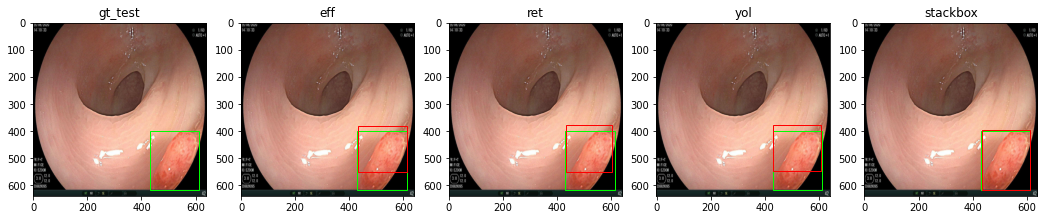

In [51]:
qt_img = len(images_list)
fig = plt.figure(figsize=(18,5))

# the gt
count = 1
for image in images_list:
    ax = fig.add_subplot(1, qt_img, count)
    imgplot = plt.imshow(img)
    ax.set_title(images_list[count-1])
    for index, row in gt_test.iterrows():
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
    
    df = globals()[image]
    if image == 'gt_test':
        pass
    else: 
        for i, row in df.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
    count+=1
